In [1]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, matthews_corrcoef
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin

In [2]:
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import re
import random
from scipy import stats
from scipy.stats import t
from itertools import chain

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import binary_cross_entropy

In [5]:
#!pip install psyke==0.8.9

In [6]:
from psyke import Extractor, Clustering, EvaluableModel
from psyke.extraction.hypercubic.strategy import AdaptiveStrategy
from psyke.extraction.hypercubic import Grid, FeatureRanker
from psyke.tuning.orchid import OrCHiD
from psyke.tuning.crash import CRASH
from psyke.utils.logic import pretty_theory
from psyke.utils import Target
from psyke.schema import LessThan, GreaterThan, Between

In [7]:
# functions to print scores for the generated rules
def print_scores(scores):
    print(f'Classification accuracy = {scores[EvaluableModel.ClassificationScore.ACCURACY][0]:.2f} (data), '
          f'{scores[EvaluableModel.ClassificationScore.ACCURACY][1]:.2f} (BB)\n'
          f'F1 = {scores[EvaluableModel.ClassificationScore.F1][0]:.2f} (data), '
          f'{scores[EvaluableModel.ClassificationScore.F1][1]:.2f} (BB)')

def get_scores(extractor, test, predictor):
    return extractor.score(test, predictor, True, True, False, task=EvaluableModel.Task.CLASSIFICATION,
                           scoring_function=[EvaluableModel.ClassificationScore.ACCURACY,
                                             EvaluableModel.ClassificationScore.F1])

In [8]:
# function to compute performance metrics
def get_results(y_pred, y_test):
    a   = accuracy_score(y_test, y_pred)
    ba  = balanced_accuracy_score(y_test, y_pred)
    p   = precision_score(y_test, y_pred)
    r   = recall_score(y_test, y_pred)
    sp  = recall_score(y_test, y_pred, pos_label=0)
    f1  = f1_score(y_test, y_pred, average="macro")
    roc = roc_auc_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    return [a, ba, p, r, sp, f1, roc, mcc]

In [9]:
# function to compute accuracy with respect to a rule-based system
def get_relative_accuracy(y_test, y_rule, y_pred):
    return sum((y_test == y_rule) & (y_rule == y_pred.round())) / sum(y_test == y_rule)
 
def get_relative_sensitivity(y_test, y_rule, y_pred):
    return sum((y_test == y_rule) & (y_test == 1) & (y_rule == y_pred.round())) / sum((y_test == y_rule) & (y_test == 1))
 
def get_relative_specificity(y_test, y_rule, y_pred):
    return sum((y_test == y_rule) & (y_test == 0) & (y_rule == y_pred.round())) / sum((y_test == y_rule) & (y_test == 0))

In [10]:
# function to generate a summary table
def get_results_table(scores_ml, scores_kbml, n_1, n_train, n_test):
    res = pd.DataFrame(index = scores_ml.columns, columns = ["ML_mean","ML_std","KB-ML_mean","KB-ML_std"])
    res["ML_mean"] = scores_ml.mean().round(3)
    res["ML_std"] = scores_ml.std().round(3)
    res["KB-ML_mean"] = scores_kbml.mean().round(3)
    res["KB-ML_std"] = scores_kbml.std().round(3)
    res["p-value"] = np.nan
    res["corr_p-value"] = np.nan
    for c in res.index:
        difference = scores_ml[c].values - scores_kbml[c].values
        # uncorrected paired t-test p-value
        t_stat_uncorrected = np.mean(difference) / np.sqrt(np.var(difference, ddof=1) / n)
        p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), n_1)
        res.loc[c,"p-value"] = p_val_uncorrected.round(4)
        # corrected paired t-test p-value
        t_stat, p_val = compute_corrected_ttest(difference, n_1, n_train, n_test)
        res.loc[c,"corr_p-value"] = p_val.round(4)
    return res

In [11]:
# function to correct the standard deviation using Nadeau and Bengio's approach.
def corrected_std(differences, n_train, n_test):
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std

# function to compute right-tailed paired t-test with corrected variance.
def compute_corrected_ttest(differences, df, n_train, n_test):
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [13]:
# function to parse rules from theories
def parse_rules(rule_string):
    opposite_signs = {
        '<': '>',
        '>': '<',
        '<=': '>=',
        '>=': '<=',
        '=<': '=>',
        '=>': '=<',
    }
    rules = []
    # predicate with rules
    rule_pattern = re.compile(r"'Outcome'\((.*?)\)\s:-\s*(.*?)\.($|\s)")
    # final predicate with no rules
    rule_pattern_end = re.compile(r"'Outcome'\((.*?)\)\.")
    # rule condition
    condition_pattern = re.compile(r'([a-zA-Z]+)\s*([=<>]+)\s*([0-9.-]+)')
    # rule interval
    interval_pattern = re.compile(r"([a-zA-Z]+)\s+in\s+\[([-+]?\d*\.?\d+),\s*([-+]?\d*\.?\d+)\]")
    for match in rule_pattern.finditer(rule_string):
        outcome = match.group(1).strip().split()[-1]
        conditions_str = match.group(2).strip()
        conditions = []
        # condition with less than / greater than
        for condition_match in condition_pattern.finditer(conditions_str):
            variable = condition_match.group(1)
            operation = condition_match.group(2)
            threshold = float(condition_match.group(3))
            conditions.append({
                "variable": variable,
                "operation": operation,
                "threshold": threshold
            })
        # condition with interval
        for condition_match in interval_pattern.finditer(conditions_str):
            variable = condition_match.group(1)
            lower_bound = float(condition_match.group(2))
            upper_bound = float(condition_match.group(3))
            conditions.extend([
                {"variable": variable,
                "operation": ">=",
                "threshold": lower_bound},
                {"variable": variable,
                "operation": "<=",
                "threshold": upper_bound}           
            ]) 
        rules.append({
            "conditions": conditions,
            "outcome": outcome
        })
    # rule with no conditions
    for match in rule_pattern_end.finditer(rule_string):
        outcome = match.group(1).strip().split()[-1]
        rules.append({
            "conditions": [],
            "outcome": outcome
        })
    return rules

In [16]:
# define rules from the knowledge base
def get_kb_rules():
    return [ {"conditions" : [{"variable" : "BMI",
                                      "operation" : "<=",
                                      "threshold" : 25},
                                     {"variable" : "Glucose",
                                      "operation" : "<=",
                                      "threshold" : 100}],
                     "outcome" : "healthy"},
                    {"conditions" : [{"variable" : "BMI",
                                      "operation" : ">=",
                                      "threshold" : 30},
                                     {"variable" : "Glucose",
                                      "operation" : ">=",
                                      "threshold" : 126}],
                     "outcome" : "diabetes"}]

In [18]:
# function to collect all variables in rules and corresponding thresholds
def get_thresholds(all_rules, test):
    # all variables in rules
    variables = {condition['variable'] for rule in all_rules for condition in rule['conditions']}
    thresholds = {variable: [] for variable in variables}
    # all thresholds in rules
    for rule in all_rules:
        for condition in rule['conditions']:
            thresholds[condition["variable"]].append(condition["threshold"])
    for key in thresholds:
        thresholds[key].append(round(test[key].min(),2))
        thresholds[key].append(round(test[key].max(),2))
        thresholds[key] = sorted(set(thresholds[key])) 
    return thresholds

In [19]:
# add intervals to rules in rule sets
def add_interval(rules, thresholds):
    # variables across all rule sets
    variables = thresholds.keys()
    # variables in this particular rule set
    vars_in_rule_set = list(set([cond['variable'] for rule in rules for cond in rule['conditions']]))
    # record intervals covered by rules
    coverage = {variable: np.full((len(thresholds[variable])-1), False) for variable in vars_in_rule_set}
    for rule in rules:
        # for each rule initialise an interval dictionary and a mask dictionary 
        #(the mask identifies the positions that will be set to 1)
        vars_in_rule = list(set([cond['variable'] for cond in rule['conditions']]))
        intervals = {variable: np.zeros(len(thresholds[variable])-1).astype("int") for variable in variables}
        mask = {variable: np.full(len(intervals[variable]), True) for variable in variables} 
        # any or the predicates with conditions
        if len(rule['conditions']) != 0:
            # parse all conditions of the rule and update the mask
            for condition in rule['conditions']:
                var = condition['variable']
                if ">" in condition['operation']:
                    mask[var] = mask[var]*(np.arange(len(intervals[var])) >= thresholds[var].index(condition['threshold']))
                elif "<" in condition['operation']:
                    mask[var] = mask[var]*(np.arange(len(intervals[var])) < thresholds[var].index(condition['threshold']))
            # remove intervals already included in previous rules
            #for var in vars_in_rule_set:
            #    mask[var] = mask[var]*(~(mask[var]*coverage[var]))
            # add conditions of the current rule to the coverage
            for var in vars_in_rule:
                coverage[var] = (coverage[var] | mask[var])    
            # set intervals
            for var in variables:
                intervals[var][mask[var]] = 1 
        # last predicate of the theory without conditions
        else:
            #include intervals not included in other rules
            for var in vars_in_rule_set:
                mask[var] = ~(coverage[var]) 
            # set intervals
            for var in variables:
                intervals[var][mask[var]] = 1 
        # concatenate all intervals into a single vector
        rule["interval"] = np.concatenate(list(intervals.values()))   
    return rules

In [20]:
def apply_condition(operation, value, threshold):
    if operation == "<=":
        return value <= threshold
    if operation == "=<":
        return value <= threshold
    elif operation == "<":
        return value < threshold
    if operation == ">=":
        return value >= threshold
    if operation == "=>":
        return value >= threshold
    elif operation == ">":
        return value > threshold

In [21]:
# retrieve vector corresponding to satisfied rule
# TO DO: add error message in case a sample does not meet the conditions
# (this shouldn't happen if the rule coverage is 100%)
def get_interval(rules, sample): 
    interval = np.nan
    for rule in rules:
        conditions_met = all(apply_condition(cond["operation"], sample[cond["variable"]],cond["threshold"]) for cond in rule['conditions'])
        if conditions_met:
            interval = rule["interval"]
            break
    return interval

In [22]:
# retrieve outcome corresponding to satisfied rule
def get_outcome(rules, sample): 
    outcome = np.nan
    for rule in rules:
        conditions_met = all(apply_condition(cond["operation"], sample[cond["variable"]],cond["threshold"]) for cond in rule['conditions'])
        if conditions_met:
            outcome = rule["outcome"]
            break
    return 1 if outcome == "diabetes" else 0

In [23]:
# define similarity metrics for XAI intervals
def similarity_xnor(row, rules1, rules2):
    i1 = get_interval(rules1, row)
    i2 = get_interval(rules2, row) 
    return sum(i1==i2)/len(i1)

def similarity_and(row, rules1, rules2):
    i1 = get_interval(rules1, row)
    i2 = get_interval(rules2, row) 
    return sum(i1*i2)/len(i1)  

def similarity_jaccard(row, rules1, rules2):
    i1 = get_interval(rules1, row)
    i2 = get_interval(rules2, row) 
    intersection = np.sum(i1 & i2)
    union = np.sum(i1 | i2)
    return intersection / union

def similarity_cosine(row, rules1, rules2):
    i1 = get_interval(rules1, row)
    i2 = get_interval(rules2, row) 
    dot_product = np.dot(i1, i2)
    norm_a = np.linalg.norm(i1)
    norm_b = np.linalg.norm(i2)
    return dot_product / (norm_a * norm_b)

def similarity_dice(row, rules1, rules2):
    i1 = get_interval(rules1, row)
    i2 = get_interval(rules2, row) 
    intersection = np.sum(i1 & i2)
    sum_ab = np.sum(i1) + np.sum(i2)
    return 2 * intersection / sum_ab

def tanimoto_similarity(row, rules1, rules2):
    i1 = get_interval(rules1, row)
    i2 = get_interval(rules2, row) 
    intersection = np.sum(i1 & i2)
    union = np.sum(i1 | i2)
    return intersection / union

In [12]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, output, target, mask, factor):
        criterion = nn.BCELoss()
        loss = criterion(output, target)
        high_cost = factor*binary_cross_entropy(output, target, weight = mask.float())
        return loss + high_cost

In [24]:
# define neural network class (fully data-driven)
class PimaClassifier_ML(nn.Module, BaseEstimator, ClassifierMixin):
    def __init__(self, n_feat):
        super().__init__()
        self.hidden1 = nn.Linear(n_feat, 12)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(12, 8)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act_output(self.output(x))
        return x

    def fit(self, X_train, y_train, epochs=25, batch_size=20, lr=0.01, verbose=False):
        loss_fn_ml = nn.BCELoss()
        optimizer = optim.Adam(self.parameters(), lr = 0.001)
        # convert to PyTorch tensors
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
        for epoch in range(epochs):
          for i in range(0, len(X_train), batch_size):
              X_batch = X_train[i:i+batch_size]
              y_batch = y_train[i:i+batch_size]
              y_pred = self(X_batch)
              loss = loss_fn_ml(y_pred, y_batch)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
          if verbose & (epoch % 5 == 0):
            print(f'Finished epoch {epoch}, latest loss {loss}')
              
    def predict_proba(self, X_test):
        X_test = torch.tensor(X_test, dtype=torch.float32)
        with torch.no_grad():
          y_pred = self(X_test)
        return y_pred.flatten().numpy()

    def predict(self, test):
        X_test = torch.tensor(test.values, dtype=torch.float32)
        with torch.no_grad():
          y_pred = self(X_test)
        y_pred = y_pred.flatten().numpy()
        return np.array(['healthy' if v == 0 else 'diabetes' for v in list(y_pred.round())])

In [25]:
# define neural network class (integrated model)
class PimaClassifier_KBML(nn.Module, BaseEstimator, ClassifierMixin):
    def __init__(self, n_feat):
        super().__init__()
        self.hidden1 = nn.Linear(n_feat, 12)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(12, 8)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act_output(self.output(x))
        return x
              
    def fit(self, X_train, y_train, mask, alpha=2, epochs=25, batch_size=20, lr=0.01, verbose=False):
        loss_fn_kb = CustomLoss()
        optimizer = optim.Adam(self.parameters(), lr = 0.001)
        # convert to PyTorch tensors
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
        mask = torch.tensor(mask).reshape(-1,1)
        for epoch in range(epochs):
          for i in range(0, len(X_train), batch_size):
              X_batch = X_train[i:i+batch_size]
              y_batch = y_train[i:i+batch_size]
              mask_batch = mask[i:i+batch_size]
              y_pred = self(X_batch)
              loss = loss_fn_kb(y_pred, y_batch, mask_batch, alpha)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
          if verbose & (epoch % 5 == 0):
            print(f'Finished epoch {epoch}, latest loss {loss}')
              
    def predict_proba(self, X_test):
        X_test = torch.tensor(X_test, dtype=torch.float32)
        with torch.no_grad():
          y_pred = self(X_test)
        return y_pred.flatten().numpy()

    def predict(self, test):
        X_test = torch.tensor(test.values, dtype=torch.float32)
        with torch.no_grad():
          y_pred = self(X_test)
        y_pred = y_pred.flatten().numpy()
        return np.array(['healthy' if v == 0 else 'diabetes' for v in list(y_pred.round())])

In [60]:
metric_dict = {"A": "Accuracy", "BA": "Balanced accuracy", "P": "Precision", "R": "Recall", "SP": "Specificity",
               "F1": "F1-score", "ROC" : "AUC ROC",  "MCC":"Matthew's corr. coeff.", "RA": "Relative accuracy"}

### RELATIVE ACCURACY vs ALPHA

In [105]:
random.seed(4)
torch.manual_seed(4)
np.random.seed(4)

In [106]:
# import dataset
dataset = pd.read_csv("pima_indians_imputed.csv", index_col = 0)
# split the dataset into features (X) and target (y)
X = dataset.iloc[:,:8].values
y = dataset.iloc[:, 8].values

# compute predicted outcome based on rule
dataset_rules = dataset.copy()
dataset_rules["Rules"] = np.nan
dataset_rules.loc[(dataset_rules["BMI"] >= 30) & (dataset_rules["Glucose"] >= 126), "Rules"] = 1
dataset_rules.loc[(dataset_rules["BMI"] <= 25) & (dataset_rules["Glucose"] <= 100), "Rules"] = 0

# identify samples correctly identified by the rules (which will be assigned heavier training weights)
mask = (dataset_rules["Rules"] == dataset_rules["Outcome"]).values

In [107]:
# set splits (10x10 repeated stratified CV)
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
splits = list(rskf.split(X, y))
# set parameters
n_train = len(list(splits[0][0]))
n_test = len(list(splits[0][1]))
n = len(splits)
n_1 = n - 1

In [232]:
# save scores and theories
scores_all = pd.DataFrame(columns=["alpha", "A", "BA", "P", "R", "SP", "F1", "ROC", "MCC", "RA", "RSE", "RSP"])

res_list = []
for r, (train_index, test_index) in enumerate(splits):
    res_array = np.empty((len(test_index),15))
    # prepare data (for training)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X[train_index,:])
    X_test = scaler.transform(X[test_index,:])
    mask_train = mask[train_index]
    y_train = y[train_index]
    y_test = y[test_index]
    y_rule = dataset_rules.loc[test_index,"Rules"].values
   
    # train ML model
    print("ML Iteration ", r)
    model = PimaClassifier_ML(X.shape[1])
    model.fit(X_train, y_train, epochs=25)
    y_pred_ml = model.predict_proba(X_test)
    scores_all.loc[len(scores_all)] = [0] + get_results(y_pred_ml.round(), y_test) + [get_relative_accuracy(y_test, y_rule, y_pred_ml.round()), 
                                            get_relative_sensitivity(y_test, y_rule, y_pred_ml.round()), 
                                            get_relative_specificity(y_test, y_rule, y_pred_ml.round())] 
    
    # save predictions
    res_array[:,0] = y_test
    res_array[:,1] = y_rule
    res_array[:,2] = y_pred_ml    
    # train KB-ML model
    print("KB-ML Iteration ", r)
    for a in range(1, 13, 1):
        alpha = a/2
        model = PimaClassifier_KBML(X.shape[1])
        model.fit(X_train, y_train, mask_train, alpha, epochs=25)
        y_pred_kbml = model.predict_proba(X_test)
        scores_all.loc[len(scores_all)] = [alpha] + get_results(y_pred_kbml.round(), y_test) + [get_relative_accuracy(y_test, y_rule, y_pred_kbml.round()), 
                                            get_relative_sensitivity(y_test, y_rule, y_pred_kbml.round()), 
                                            get_relative_specificity(y_test, y_rule, y_pred_kbml.round())]      
        res_array[:,a+2] = y_pred_kbml
    
    res_list.append(res_array)   

ML Iteration  0
KB-ML Iteration  0
ML Iteration  1
KB-ML Iteration  1
ML Iteration  2
KB-ML Iteration  2
ML Iteration  3
KB-ML Iteration  3
ML Iteration  4
KB-ML Iteration  4
ML Iteration  5
KB-ML Iteration  5
ML Iteration  6
KB-ML Iteration  6
ML Iteration  7
KB-ML Iteration  7
ML Iteration  8
KB-ML Iteration  8
ML Iteration  9
KB-ML Iteration  9
ML Iteration  10
KB-ML Iteration  10
ML Iteration  11
KB-ML Iteration  11
ML Iteration  12
KB-ML Iteration  12
ML Iteration  13
KB-ML Iteration  13
ML Iteration  14
KB-ML Iteration  14
ML Iteration  15
KB-ML Iteration  15
ML Iteration  16
KB-ML Iteration  16
ML Iteration  17
KB-ML Iteration  17
ML Iteration  18
KB-ML Iteration  18
ML Iteration  19
KB-ML Iteration  19
ML Iteration  20
KB-ML Iteration  20
ML Iteration  21
KB-ML Iteration  21
ML Iteration  22
KB-ML Iteration  22
ML Iteration  23
KB-ML Iteration  23
ML Iteration  24
KB-ML Iteration  24
ML Iteration  25
KB-ML Iteration  25
ML Iteration  26
KB-ML Iteration  26
ML Iteration  27
KB-M

In [219]:
#scores_all.to_csv("ra_alpha_scores.csv")

In [102]:
scores_all = pd.read_csv("ra_alpha_scores.csv", index_col = 0)

In [104]:
res_stats = get_results_table(scores_all[scores_all["alpha"]==0], scores_all[scores_all["alpha"]==1.5], n_1, n_train, n_test)
res_stats

ML_mean  ML_std  KB-ML_mean  KB-ML_std  p-value  corr_p-value
alpha    0.000   0.000       1.500      0.000   0.0000         0.000
A        0.762   0.043       0.765      0.046   0.2093         0.408
BA       0.724   0.051       0.747      0.054   0.0000         0.045
P        0.684   0.074       0.657      0.064   0.0000         0.046
R        0.599   0.094       0.689      0.102   0.0000         0.001
SP       0.850   0.046       0.805      0.052   0.0000         0.000
F1       0.729   0.051       0.743      0.051   0.0001         0.139
ROC      0.724   0.051       0.747      0.054   0.0000         0.045
MCC      0.466   0.100       0.491      0.102   0.0003         0.153
RA       0.903   0.066       0.965      0.041   0.0000         0.001
RSE      0.873   0.083       0.954      0.052   0.0000         0.002
RSP      1.000   0.000       1.000      0.000      NaN           NaN

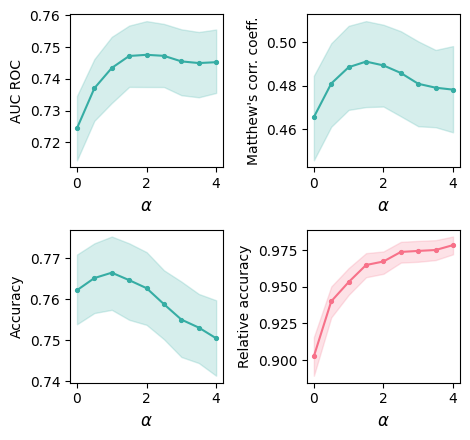

In [94]:
# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(4.8, 4.5))
# Flatten the axes array for easy indexing
palette = sns.color_palette("husl", 4)
colors = [palette[2],palette[2],palette[2],palette[0]]
axes = axes.flatten()
# Plot each metric on a separate subplot
for i, metric in enumerate(["ROC", "MCC", "A", "RA"]):
    sns.lineplot(data=scores_all[scores_all["alpha"] <= 4], x="alpha", y=metric, marker='.', markeredgecolor=None, ax=axes[i], 
                 color = colors[i])
    axes[i].set_ylabel(metric_dict[metric])
    axes[i].set_xlabel(r'$\alpha$', fontsize=12)
plt.tight_layout()
#plt.savefig("ra_alpha.pdf")
#plt.savefig("ra_alpha.svg")

### RELATIVE ACCURACY for alpha = 1.5

In [350]:
alpha = 1.5

test_idxs = []
pred_mls = []
pred_kbmls = []

for r, (train_index, test_index) in enumerate(splits):
    res_array = np.empty((len(test_index),15))
    # prepare data (for training)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X[train_index,:])
    X_test = scaler.transform(X[test_index,:])
    mask_train = mask[train_index]
    y_train = y[train_index]
    y_test = y[test_index]
    y_rule = dataset_rules.loc[test_index,"Rules"].values   
    # train ML model
    print("ML Iteration ", r)
    model = PimaClassifier_ML(X.shape[1])
    model.fit(X_train, y_train, epochs=25)  
    y_pred_ml = model.predict_proba(X_test)
    # train KB-ML model
    print("KB-ML Iteration ", r)
    model = PimaClassifier_KBML(X.shape[1])
    model.fit(X_train, y_train, mask_train, alpha, epochs=25)
    y_pred_kbml = model.predict_proba(X_test)    
    # save predictions
    test_idxs.extend(list(test_index))
    pred_mls.extend(list(y_pred_ml.round()))
    pred_kbmls.extend(list(y_pred_kbml.round()))

ML Iteration  0
KB-ML Iteration  0
ML Iteration  1
KB-ML Iteration  1
ML Iteration  2
KB-ML Iteration  2
ML Iteration  3
KB-ML Iteration  3
ML Iteration  4
KB-ML Iteration  4
ML Iteration  5
KB-ML Iteration  5
ML Iteration  6
KB-ML Iteration  6
ML Iteration  7
KB-ML Iteration  7
ML Iteration  8
KB-ML Iteration  8
ML Iteration  9
KB-ML Iteration  9
ML Iteration  10
KB-ML Iteration  10
ML Iteration  11
KB-ML Iteration  11
ML Iteration  12
KB-ML Iteration  12
ML Iteration  13
KB-ML Iteration  13
ML Iteration  14
KB-ML Iteration  14
ML Iteration  15
KB-ML Iteration  15
ML Iteration  16
KB-ML Iteration  16
ML Iteration  17
KB-ML Iteration  17
ML Iteration  18
KB-ML Iteration  18
ML Iteration  19
KB-ML Iteration  19
ML Iteration  20
KB-ML Iteration  20
ML Iteration  21
KB-ML Iteration  21
ML Iteration  22
KB-ML Iteration  22
ML Iteration  23
KB-ML Iteration  23
ML Iteration  24
KB-ML Iteration  24
ML Iteration  25
KB-ML Iteration  25
ML Iteration  26
KB-ML Iteration  26
ML Iteration  27
KB-M

In [494]:
res_df = pd.DataFrame({"idx" : test_idxs, "pred_ml" : pred_mls, "pred_kbml" : pred_kbmls}).groupby("idx").mean().round()

In [ ]:
#res_df.to_csv("scores_alpha15.csv")

In [ ]:
res_df = pd.read_csv("scores_alpha15.csv", index_col = 0)

In [495]:
res_df["outcome"] = dataset["Outcome"]
res_df["rules"] = dataset_rules["Rules"]
res_df["eq"] = res_df["outcome"]==res_df["rules"]
res_df = res_df.sort_values(['eq','rules','outcome','pred_ml','pred_kbml'], ascending=[False,False,False,False,False])
res_df = res_df.reset_index(drop = True)
res_df = res_df.fillna(0.5)
res_df.columns = ["DD-ML", "KB-ML", "Outcome", "KB", "EQ"]

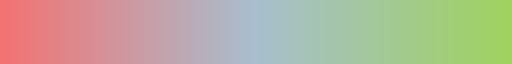

In [574]:
#m = sns.color_palette("colorblind")
#cmap = LinearSegmentedColormap.from_list('rg', ["#ee4040", "#a2adb8", "#8bc94d"], N=256) 
cmap = LinearSegmentedColormap.from_list('rg', ["#f47272", "#a8bfcf", "#9fd35e"], N=256) 
#cmap = LinearSegmentedColormap.from_list('rg', [m[3], m[7], m[2]], N=256)
cmap

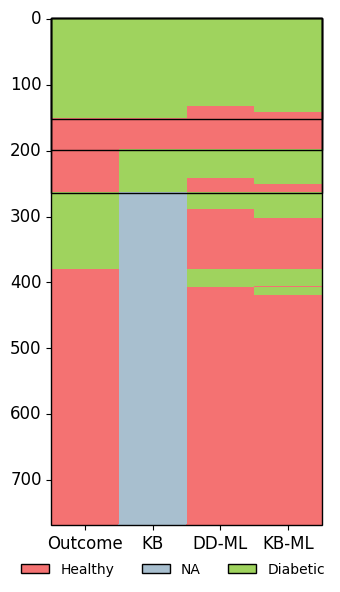

In [576]:
plt.rcParams['patch.edgecolor'] = 'none'
# Your plotting code here
fig, axes = plt.subplots(figsize=(3.5, 6))
c = sns.color_palette("tab10")
sns.heatmap(res_df[["Outcome", "KB", "DD-ML", "KB-ML"]], cmap=cmap, cbar=False, alpha=1, yticklabels = 100, linewidths=0.1, ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), rotation=0)
axes.tick_params(axis='both', which='major', labelsize=12)
colors = axes.collections[0].get_facecolors()
axes.collections[0].set_edgecolors(colors)

axes.add_patch(Rectangle((0, 0), 4, sum(res_df["EQ"]), fill=False, edgecolor="black", lw=1, clip_on=False))
axes.add_patch(Rectangle((0, 0), 4, len(res_df[(res_df["EQ"]==True)&(res_df["KB"]==1)]),fill=False, edgecolor="black", lw=1, clip_on=False))
axes.add_patch(Rectangle((0, 0), 4, len(res_df[res_df["KB"]!=0.5]),fill=False, edgecolor="black", lw=1, clip_on=False))
axes.add_patch(Rectangle((0, 0), 4, len(res_df),fill=False, edgecolor="black", lw=1, clip_on=False))

legend_elements = [
    Patch(facecolor="#f47272", edgecolor="black", label="Healthy"),
    Patch(facecolor="#a8bfcf", edgecolor="black", label="NA"),
    Patch(facecolor="#9fd35e", edgecolor="black", label="Diabetic")
]

legend = axes.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.45, -0.05), ncol=3, fontsize=10)
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_facecolor('none')
legend.get_frame().set_edgecolor('none')
plt.subplots_adjust(hspace=0.2)
plt.tight_layout()
#plt.savefig("pima_cases.pdf")
#plt.savefig("pima_cases.svg")

### EXPLAINATION DISTANCE METRICS based on binary intervals - CART varying tree depth

In [848]:
random.seed(4)
torch.manual_seed(4)
np.random.seed(4)

In [849]:
# import dataset
dataset = pd.read_csv("pima_indians_imputed.csv", index_col = 0)
# split the dataset into features (X) and target (y)
X = dataset.iloc[:,:8].values
y = dataset.iloc[:, 8].values

# compute predicted outcome based on rule
dataset_rules = dataset.copy()
dataset_rules["Rules"] = np.nan
dataset_rules.loc[(dataset_rules["BMI"] >= 30) & (dataset_rules["Glucose"] >= 126), "Rules"] = 1
dataset_rules.loc[(dataset_rules["BMI"] <= 25) & (dataset_rules["Glucose"] <= 100), "Rules"] = 0

# identify samples correctly identified by the rules (which will be assigned heavier training weights)
mask = (dataset_rules["Rules"] == dataset_rules["Outcome"]).values
alpha = 1.5

In [850]:
# set splits (10x10 repeated stratified CV)
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
splits = list(rskf.split(X, y))
# set parameters
n_train = len(list(splits[0][0]))
n_test = len(list(splits[0][1]))
n = len(splits)
n_1 = n - 1

In [851]:
# save scores and theories
scores_all = pd.DataFrame(columns=["sub","model","depth","A_data","A_BB","F1_data","F1_BB","XNOR","AND","JAC","COS","DICE","TANI"])
res_list = []
ml_theories = []
kbml_theories = []

for r, (train_index, test_index) in enumerate(splits):
    res_array = np.empty((len(test_index),6))
    # prepare data (for training)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X[train_index,:])
    X_test = scaler.transform(X[test_index,:])
    mask_train = mask[train_index]
    mask_test = mask[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    y_rule = dataset_rules.loc[test_index,"Rules"].values
    # prepare data (for explaining)
    train = dataset.loc[train_index]
    train.loc[:,dataset.columns[:-1]] = X_train
    test = dataset.loc[test_index]
    test.loc[:,dataset.columns[:-1]] = X_test
    test["Outcome"].replace({0: 'healthy', 1: 'diabetes'}, inplace = True)
    test_samples = dataset[(dataset_rules["Rules"].notna()) & (dataset.index.isin(test_index))]
    x = pd.concat([train, test]).reset_index(drop = True).drop(columns = "Outcome")
    # get normalization scheme
    normalization = {key: (m, s) for key, m, s in zip(dataset.columns, scaler.mean_, scaler.scale_)}
    
    # train ML model
    model_ml = PimaClassifier_ML(X.shape[1])
    print("ML Iteration ", r)
    model_ml.fit(X_train, y_train, epochs=25)
    y_pred_ml = model_ml.predict_proba(X_test)
    
    # train KB-ML model
    model_kbml = PimaClassifier_KBML(X.shape[1])
    print("KB-ML Iteration ", r)
    model_kbml.fit(X_train, y_train, mask_train, alpha = alpha, epochs=25)
    y_pred_kbml = model_kbml.predict_proba(X_test)
    
    for depth in range(2,13):
        print("Depth ", depth)
        
        # explain ML model
        explainer = Extractor.cart(model_ml, max_depth=depth, max_leaves=depth, simplify=True, normalization=normalization)
        theory = explainer.extract(train)  
        ml_rules_str = pretty_theory(theory)
        ml_theories.append(pretty_theory(theory)) 
        scores, completeness = get_scores(explainer, test, model_ml)
        ml_scores = [value for sublist in scores.values() for value in sublist]
        print(f'\nPerformance ({explainer.n_rules} rules with {completeness * 100:.2f}% coverage):')
        print_scores(scores)
        print('\nExtracted rules:\n\n' + pretty_theory(theory) + "\n\n")
        
        # explain KB-ML model
        explainer = Extractor.cart(model_kbml, max_depth=depth, max_leaves=depth, simplify=True, normalization=normalization)
        theory = explainer.extract(train)
        kbml_rules_str = pretty_theory(theory)
        kbml_theories.append(pretty_theory(theory))
        scores, completeness = get_scores(explainer, test, model_kbml)
        kbml_scores = [value for sublist in scores.values() for value in sublist]
        print(f'\nPerformance ({explainer.n_rules} rules with {completeness * 100:.2f}% coverage):')
        print_scores(scores)
        print('\nExtracted rules:\n\n' + pretty_theory(theory) + "\n\n")
    
        # parse theory rules
        kb_rules = get_kb_rules()
        ml_rules = parse_rules(ml_rules_str)
        kbml_rules = parse_rules(kbml_rules_str)
        # add XAI intervals to rules
        thresholds = get_thresholds(kb_rules + ml_rules + kbml_rules, dataset)
        kb_rules = add_interval(kb_rules, thresholds)
        ml_rules = add_interval(ml_rules, thresholds)
        kbml_rules = add_interval(kbml_rules, thresholds)

        # compute similarity
        # sum over all samples with predictions
        # ML
        test_samples = dataset.loc[test_index[~np.isnan(y_rule)]]
        test_samples["XNOR_ML"] = test_samples.round(2).apply(lambda row: similarity_xnor(row, kb_rules, ml_rules), axis = 1)
        test_samples["AND_ML"] = test_samples.round(2).apply(lambda row: similarity_and(row, kb_rules, ml_rules), axis = 1)
        test_samples["JAC_ML"] = test_samples.round(2).apply(lambda row: similarity_jaccard(row, kb_rules, ml_rules), axis = 1)
        test_samples["COS_ML"] = test_samples.round(2).apply(lambda row: similarity_cosine(row, kb_rules, ml_rules), axis = 1)
        test_samples["DICE_ML"] = test_samples.round(2).apply(lambda row: similarity_dice(row, kb_rules, ml_rules), axis = 1)
        test_samples["TANI_ML"] = test_samples.round(2).apply(lambda row: tanimoto_similarity(row, kb_rules, ml_rules), axis = 1)
        ml_similarities = list(test_samples[["XNOR_ML","AND_ML","JAC_ML","COS_ML","DICE_ML","TANI_ML"]].mean())
        # KB-ML
        test_samples["XNOR_KBML"] = test_samples.round(2).apply(lambda row: similarity_xnor(row, kb_rules, kbml_rules), axis = 1)
        test_samples["AND_KBML"] = test_samples.round(2).apply(lambda row: similarity_and(row, kb_rules, kbml_rules), axis = 1)
        test_samples["JAC_KBML"] = test_samples.round(2).apply(lambda row: similarity_jaccard(row, kb_rules, kbml_rules), axis = 1)
        test_samples["COS_KBML"] = test_samples.round(2).apply(lambda row: similarity_cosine(row, kb_rules, kbml_rules), axis = 1)
        test_samples["DICE_KBML"] = test_samples.round(2).apply(lambda row: similarity_dice(row, kb_rules, kbml_rules), axis = 1)
        test_samples["TANI_KBML"] = test_samples.round(2).apply(lambda row: tanimoto_similarity(row, kb_rules, kbml_rules), axis = 1)
        kbml_similarities = list(test_samples[["XNOR_KBML","AND_KBML","JAC_KBML","COS_KBML","DICE_KBML","TANI_KBML"]].mean())
        # save scores
        scores_all.loc[len(scores_all)] = ["all", "ML", depth] + ml_scores +  ml_similarities
        scores_all.loc[len(scores_all)] = ["all", "KB-ML", depth] + kbml_scores + kbml_similarities
        
        # sum over all samples with correct predictions
        test_samples = dataset.loc[test_index[(y_rule==y_test) & (y_rule==y_pred_ml.round()) & (y_rule==y_pred_kbml.round())]]
        test_samples["XNOR_ML"] = test_samples.round(2).apply(lambda row: similarity_xnor(row, kb_rules, ml_rules), axis = 1)
        test_samples["AND_ML"] = test_samples.round(2).apply(lambda row: similarity_and(row, kb_rules, ml_rules), axis = 1)
        test_samples["JAC_ML"] = test_samples.round(2).apply(lambda row: similarity_jaccard(row, kb_rules, ml_rules), axis = 1)
        test_samples["COS_ML"] = test_samples.round(2).apply(lambda row: similarity_cosine(row, kb_rules, ml_rules), axis = 1)
        test_samples["DICE_ML"] = test_samples.round(2).apply(lambda row: similarity_dice(row, kb_rules, ml_rules), axis = 1)
        test_samples["TANI_ML"] = test_samples.round(2).apply(lambda row: tanimoto_similarity(row, kb_rules, ml_rules), axis = 1)
        ml_similarities = list(test_samples[["XNOR_ML","AND_ML","JAC_ML","COS_ML","DICE_ML","TANI_ML"]].mean())
        # KB-ML
        test_samples["XNOR_KBML"] = test_samples.round(2).apply(lambda row: similarity_xnor(row, kb_rules, kbml_rules), axis = 1)
        test_samples["AND_KBML"] = test_samples.round(2).apply(lambda row: similarity_and(row, kb_rules, kbml_rules), axis = 1)
        test_samples["JAC_KBML"] = test_samples.round(2).apply(lambda row: similarity_jaccard(row, kb_rules, kbml_rules), axis = 1)
        test_samples["COS_KBML"] = test_samples.round(2).apply(lambda row: similarity_cosine(row, kb_rules, kbml_rules), axis = 1)
        test_samples["DICE_KBML"] = test_samples.round(2).apply(lambda row: similarity_dice(row, kb_rules, kbml_rules), axis = 1)
        test_samples["TANI_KBML"] = test_samples.round(2).apply(lambda row: tanimoto_similarity(row, kb_rules, kbml_rules), axis = 1)
        kbml_similarities = list(test_samples[["XNOR_KBML","AND_KBML","JAC_KBML","COS_KBML","DICE_KBML","TANI_KBML"]].mean())
        # save scores
        scores_all.loc[len(scores_all)] = ["correct", "ML", depth] + ml_scores +  ml_similarities
        scores_all.loc[len(scores_all)] = ["correct", "KB-ML", depth] + kbml_scores + kbml_similarities        

ML Iteration  0
KB-ML Iteration  0
Depth  2

Performance (2 rules with 100.00% coverage):
Classification accuracy = 0.79 (data), 0.87 (BB)
F1 = 0.79 (data), 0.87 (BB)

Extracted rules:

'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, healthy) :-
    Glucose =< 139.5.
'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, diabetes).



Performance (2 rules with 100.00% coverage):
Classification accuracy = 0.78 (data), 0.87 (BB)
F1 = 0.78 (data), 0.87 (BB)

Extracted rules:

'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, healthy) :-
    Glucose =< 132.5.
'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, diabetes).


Depth  3

Performance (3 rules with 100.00% coverage):
Classification accuracy = 0.79 (data), 0.87 (BB)
F1 = 0.79 (data), 0.87 (BB)

Extracted rules:


In [868]:
#scores_all.to_csv("scores_cart_depth_leaves_all_correct.csv")

In [842]:
scores_all = pd.read_csv("scores_cart_depth_leaves_all_correct.csv", index_col = 0)

In [852]:
scores_all = scores_all.replace({"ML":"DD-ML"})
scores_all = scores_all.sort_values("model", ascending = False)

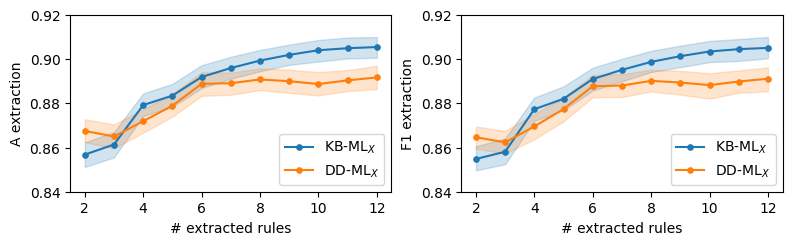

In [863]:
legend_labels = ['KB-ML$_X$', 'DD-ML$_X$']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,2.5), sharex = True)
axes = axes.flatten()
sns.lineplot(scores_all, x = "depth", hue = "model", y = "A_BB", ax=axes[0], marker='.', markersize = 8, markeredgecolor=None)
axes[0].set_ylabel("A extraction")
axes[0].set_ylim([0.84,0.92])
handles, previous_labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles, labels=legend_labels, loc='lower right')
axes[0].set_xlabel("# extracted rules")

sns.lineplot(scores_all, x = "depth", hue = "model", y = "F1_BB", ax=axes[1], marker='.', markersize = 8, markeredgecolor=None)
axes[1].set_ylabel("F1 extraction")
axes[1].set_ylim([0.84,0.92])
handles, previous_labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles=handles, labels=legend_labels, loc='lower right')
axes[1].set_xlabel("# extracted rules")

plt.tight_layout(pad = 0.7, rect=[0.0, 0.01, 0.99, 0.99])
#plt.savefig("cart_depth_acc.svg")
#plt.savefig("cart_depth_acc.pdf")

In [864]:
#scores_sub = scores_all[scores_all["sub"]=="correct"].drop(columns = "sub")
scores_sub = scores_all[scores_all["sub"]=="correct"].drop(columns = "sub")
# compute all p-values
pval_sub = pd.DataFrame(columns = ['XNOR','AND','JAC','COS','DICE','TANI'])
for depth in range(2,13):
    res_stats = get_results_table(scores_sub[(scores_sub["depth"]==depth) & (scores_sub["model"]=="DD-ML")].drop(columns = "model"), 
                                  scores_sub[(scores_sub["depth"]==depth) & (scores_sub["model"]=="KB-ML")].drop(columns = "model"), 
                                  99, 692, 76)
    pval_sub.loc[depth] = res_stats.loc[['XNOR','AND','JAC','COS','DICE','TANI'],"corr_p-value"]
# compute all means
means_sub = scores_sub.groupby(["depth","model",]).mean()

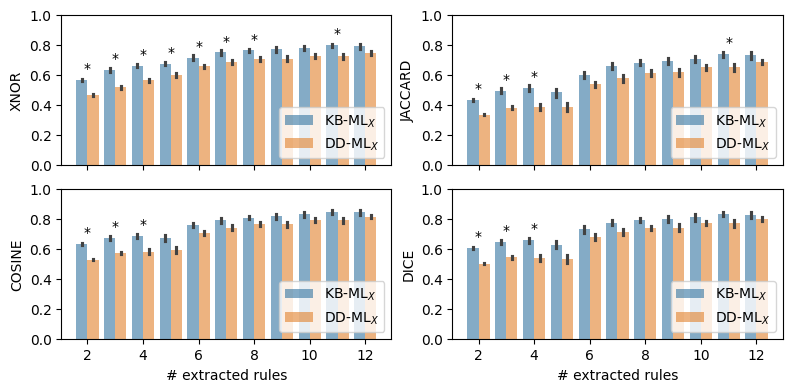

In [865]:
metrics_names = ['XNOR','JACCARD','COSINE','DICE']
legend_labels = ['KB-ML$_X$', 'DD-ML$_X$']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,4), sharex = True)
axes = axes.flatten()
for i, metric in enumerate(['XNOR', 'JAC', 'COS', 'DICE']):
    sns.barplot(scores_sub, x = "depth", hue = "model", y = metric, ax=axes[i], alpha = 0.6, native_scale=True)
    handles, previous_labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=handles, labels=legend_labels, loc='lower right')
    axes[i].set_ylim([0,1])
    axes[i].set_ylabel(metrics_names[i])
    axes[i].set_xlabel("# extracted rules")
    for depth in range(2,13):
        if pval_sub.loc[depth,metric] < 0.05:
            axes[i].text(depth, means_sub.loc[(depth, "KB-ML"),metric] + 0.05, '*', ha='center')
plt.tight_layout(pad = 0.7, rect=[0.0, 0.01, 0.99, 0.99])
#plt.savefig("cart_depth_sub.svg")
#plt.savefig("cart_depth_sub.pdf")

In [866]:
scores_sub = scores_all[scores_all["sub"]=="all"].drop(columns = "sub")
#scores_sub = scores_all[scores_all["sub"]=="correct"].drop(columns = "sub")
# compute all p-values
pval_sub = pd.DataFrame(columns = ['XNOR','AND','JAC','COS','DICE','TANI'])
for depth in range(2,13):
    res_stats = get_results_table(scores_sub[(scores_sub["depth"]==depth) & (scores_sub["model"]=="DD-ML")].drop(columns = "model"), 
                                  scores_sub[(scores_sub["depth"]==depth) & (scores_sub["model"]=="KB-ML")].drop(columns = "model"), 
                                  99, 692, 76)
    pval_sub.loc[depth] = res_stats.loc[['XNOR','AND','JAC','COS','DICE','TANI'],"corr_p-value"]
# compute all means
means_sub = scores_sub.groupby(["depth","model",]).mean()

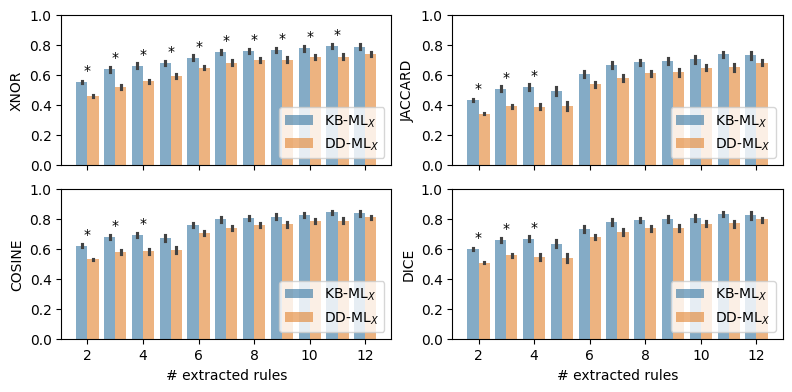

In [867]:
metrics_names = ['XNOR','JACCARD','COSINE','DICE']
legend_labels = ['KB-ML$_X$', 'DD-ML$_X$']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,4), sharex = True)
axes = axes.flatten()
for i, metric in enumerate(['XNOR', 'JAC', 'COS', 'DICE']):
    sns.barplot(scores_sub, x = "depth", hue = "model", y = metric, ax=axes[i], alpha = 0.6, native_scale=True)
    handles, previous_labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=handles, labels=legend_labels, loc='lower right')
    axes[i].set_ylim([0,1])
    axes[i].set_ylabel(metrics_names[i])
    axes[i].set_xlabel("# extracted rules")
    for depth in range(2,13):
        if pval_sub.loc[depth,metric] < 0.05:
            axes[i].text(depth, means_sub.loc[(depth, "KB-ML"),metric] + 0.05, '*', ha='center')
plt.tight_layout(pad = 0.7, rect=[0.0, 0.01, 0.99, 0.99])
#plt.savefig("cart_depth_all.svg")
#plt.savefig("cart_depth_all.pdf")

### ROBUSTNESS ANALYSIS

In [786]:
random.seed(4)
torch.manual_seed(4)
np.random.seed(4)

In [787]:
# import dataset
dataset = pd.read_csv("pima_indians_imputed.csv", index_col = 0)
# split the dataset into features (X) and target (y)
X = dataset.iloc[:,:8].values
y = dataset.iloc[:, 8].values

# compute predicted outcome based on rule
dataset_rules = dataset.copy()
dataset_rules["Rules"] = np.nan
dataset_rules.loc[(dataset_rules["BMI"] >= 30) & (dataset_rules["Glucose"] >= 126), "Rules"] = 1
dataset_rules.loc[(dataset_rules["BMI"] <= 25) & (dataset_rules["Glucose"] <= 100), "Rules"] = 0

# identify samples correctly identified by the rules (which will be assigned heavier training weights)
mask = (dataset_rules["Rules"] == dataset_rules["Outcome"]).values
alpha = 1.5

In [788]:
# set splits (10x10 repeated stratified CV)
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
splits = list(rskf.split(X, y))
# set parameters
n_train = len(list(splits[0][0]))
n_test = len(list(splits[0][1]))
n = len(splits)
n_1 = n - 1

In [789]:
# save scores and theories
scores_all = pd.DataFrame(columns=["model", "depth", "A_data", "A_BB", "F1_data", "F1_BB", "XNOR", "AND", "JAC", "COS", "DICE", "TANI"])
res_list = []
ml_theories = []
kbml_theories = []
ml_dict = {key: [] for key in range(2, 13)}
kbml_dict = {key: [] for key in range(2, 13)}  

for r, (train_index, test_index) in enumerate(splits):
    res_array = np.empty((len(test_index),6))
    # prepare data (for training)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X[train_index,:])
    X_test = scaler.transform(X[test_index,:])
    mask_train = mask[train_index]
    y_train = y[train_index]
    y_test = y[test_index]
    y_rule = dataset_rules.loc[test_index,"Rules"].values
    # prepare data (for explaining)
    train = dataset.loc[train_index]
    train.loc[:,dataset.columns[:-1]] = X_train
    test = dataset.loc[test_index]
    test.loc[:,dataset.columns[:-1]] = X_test
    test["Outcome"].replace({0: 'healthy', 1: 'diabetes'}, inplace = True)
    test_samples = dataset[(dataset_rules["Rules"].notna()) & (dataset.index.isin(test_index))]
    x = pd.concat([train, test]).reset_index(drop = True).drop(columns = "Outcome")
    # get normalization scheme
    normalization = {key: (m, s) for key, m, s in zip(dataset.columns, scaler.mean_, scaler.scale_)}
    
    # train ML model
    model_ml = PimaClassifier_ML(X.shape[1])
    print("ML Iteration ", r)
    model_ml.fit(X_train, y_train, epochs=25)
    y_pred_ml = model_ml.predict_proba(X_test)
    
    # train KB-ML model
    model_kbml = PimaClassifier_KBML(X.shape[1])
    print("KB-ML Iteration ", r)
    model_kbml.fit(X_train, y_train, mask_train, alpha = alpha, epochs=25)
    y_pred_kbml = model_kbml.predict_proba(X_test)
    
    for depth in range(2,13):
        print("Depth ", depth)
        
        # explain ML model
        explainer = Extractor.cart(model_ml, max_depth=depth, max_leaves=depth, simplify=True, normalization=normalization)
        theory = explainer.extract(train)  
        ml_rules_str = pretty_theory(theory)
        ml_theories.append(pretty_theory(theory)) 
        scores, completeness = get_scores(explainer, test, model_ml)
        ml_scores = [value for sublist in scores.values() for value in sublist]
        print(f'\nPerformance ({explainer.n_rules} rules with {completeness * 100:.2f}% coverage):')
        print_scores(scores)
        print('\nExtracted rules:\n\n' + pretty_theory(theory) + "\n\n")
        
        # explain KB-ML model
        explainer = Extractor.cart(model_kbml, max_depth=depth, max_leaves=depth, simplify=True, normalization=normalization)
        theory = explainer.extract(train)
        kbml_rules_str = pretty_theory(theory)
        kbml_theories.append(pretty_theory(theory))
        scores, completeness = get_scores(explainer, test, model_kbml)
        kbml_scores = [value for sublist in scores.values() for value in sublist]
        print(f'\nPerformance ({explainer.n_rules} rules with {completeness * 100:.2f}% coverage):')
        print_scores(scores)
        print('\nExtracted rules:\n\n' + pretty_theory(theory) + "\n\n")
    
        # parse theory rules
        kb_rules = get_kb_rules()
        ml_rules = parse_rules(ml_rules_str)
        kbml_rules = parse_rules(kbml_rules_str)

        #save all theories
        ml_dict[depth].append(ml_rules)
        kbml_dict[depth].append(kbml_rules)

ML Iteration  0
KB-ML Iteration  0
Depth  2

Performance (2 rules with 100.00% coverage):
Classification accuracy = 0.79 (data), 0.87 (BB)
F1 = 0.79 (data), 0.87 (BB)

Extracted rules:

'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, healthy) :-
    Glucose =< 139.5.
'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, diabetes).



Performance (2 rules with 100.00% coverage):
Classification accuracy = 0.78 (data), 0.87 (BB)
F1 = 0.78 (data), 0.87 (BB)

Extracted rules:

'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, healthy) :-
    Glucose =< 132.5.
'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, diabetes).


Depth  3

Performance (3 rules with 100.00% coverage):
Classification accuracy = 0.79 (data), 0.87 (BB)
F1 = 0.79 (data), 0.87 (BB)

Extracted rules:


In [790]:
test_samples = dataset[(dataset_rules["Rules"].notna())] # on samples covered by rules

In [791]:
res_all = np.zeros((11, 2))

for depth in range(2,13):
    print("depth", depth)
    all_ml_rules = ml_dict[depth]
    all_kbml_rules = kbml_dict[depth]
    thresholds = get_thresholds(list(chain(*all_ml_rules)) + list(chain(*all_kbml_rules)), dataset)
    all_ml_rules_int  = [add_interval(ml_rules, thresholds) for ml_rules in all_ml_rules]
    all_kbml_rules_int  = [add_interval(ml_rules, thresholds) for ml_rules in all_kbml_rules]
    res_ml = np.zeros((100, 100))
    res_kbml = np.zeros((100, 100))
    for i in range(100):
        for j in range(i):
            res_ml[i,j] = test_samples.round(2).apply(
                        lambda row: similarity_xnor(row,all_ml_rules_int[i],all_ml_rules_int[j]),axis = 1).mean()
            res_kbml[i,j] = test_samples.round(2).apply(
                        lambda row: similarity_xnor(row,all_kbml_rules_int[i],all_kbml_rules_int[j]),axis = 1).mean()
    res_all[depth-2,0] = sum(sum(res_ml))/(100*99/2)
    print(round(sum(sum(res_ml))/(100*99/2),3))
    res_all[depth-2,1] = sum(sum(res_kbml))/(100*99/2)
    print(round(sum(sum(res_kbml))/(100*99/2),3))
    print()

depth 2
0.834
0.814

depth 3
0.852
0.835

depth 4
0.806
0.841

depth 5
0.792
0.806

depth 6
0.824
0.848

depth 7
0.837
0.879

depth 8
0.847
0.884

depth 9
0.822
0.871

depth 10
0.841
0.873

depth 11
0.824
0.892

depth 12
0.852
0.874



In [795]:
rob_all = pd.DataFrame(res_all, index = range(2,13), columns = ["DD-ML","KB-ML"])

In [ ]:
#rob_all.to_csv("all_robustness.csv")

In [ ]:
rob_all = pd.read_csv("all_robustness.csv", index_col = 0)

In [800]:
rob_all = rob_all.reset_index().rename(columns = {"index":"depth"})
rob_all = pd.melt(rob_all, id_vars=['depth'], var_name='model', value_name='value')
rob_all = rob_all.sort_values("model", ascending = False)

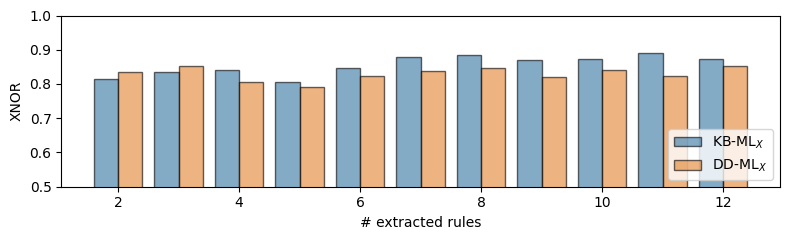

In [831]:
legend_labels = ['KB-ML$_X$', 'DD-ML$_X$']
fig, ax = plt.subplots(figsize=(8,2.5))
sns.barplot(rob_all, x = "depth", y = "value", hue = "model", alpha = 0.6, edgecolor = "k", native_scale = True) 
ax.set_xlabel("# extracted rules")
ax.set_ylabel("XNOR")
plt.ylim([0.5, 1])
handles, previous_labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=legend_labels, loc='lower right')
plt.tight_layout()
plt.savefig("cart_rob.svg")
plt.savefig("cart_rob.pdf")